In [108]:
import mne
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [82]:
def preprocess_eeg(file_path, label, epoch_length=2, overlap=0.5):
    # Load the raw EEG data
    raw_data = mne.io.read_raw_bdf(file_path, preload=True)
    
    # Apply a 1 Hz high-pass filter
    raw_data.filter(l_freq=1.0, h_freq=None, fir_design='firwin')
    
    # Segment the data based on epoch length (seconds) with 50% overlap
    sfreq = raw_data.info['sfreq']  # Sampling frequency
    epoch_samples = int(epoch_length * sfreq)
    overlap_samples = int(overlap * epoch_samples)
    
    # Create epochs
    epochs = []
    labels = []
    for start in range(0, len(raw_data) - epoch_samples, epoch_samples - overlap_samples):
        epoch = raw_data[:, start:start + epoch_samples][0]
        epochs.append(epoch)
        labels.append(label)
    
    epochs = np.array(epochs)
    labels = np.array(labels)
    
    # Normalize: Normalize the EEG 
    scaler = StandardScaler()
    epochs = np.array([scaler.fit_transform(epoch.T).T for epoch in epochs])
    
    return epochs, labels

# List of file paths and corresponding labels
file_paths = [
    r'D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_050.bdf',
    r'D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf',
    r'D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf',
    r'D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf'
]
labels = [0.5, 0.75, 1.0, 1.25]

# Combine data from all files
all_epochs = []
all_labels = []
for file_path, label in zip(file_paths, labels):
    epochs, epoch_labels = preprocess_eeg(file_path, label)
    all_epochs.append(epochs)
    all_labels.append(epoch_labels)

all_epochs = np.concatenate(all_epochs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

label_mapping = {0.5: 0, 0.75: 1, 1.0: 2, 1.25: 3}
reverse_mapping = {v: k for k, v in label_mapping.items()}  # For interpreting results later

all_mapped_labels = [label_mapping[label] for label in all_labels]

X_train, X_temp, y_train, y_temp = train_test_split(all_epochs, all_mapped_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# (epochs, channels, samples, 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print(f'Training set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Testing set shape: {X_test.shape}')

Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_050.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 200191  =      0.000 ...   390.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Training set shape: (1031, 129, 1024, 1)
Validation set shape: (221, 129, 1024, 1)
Testing set shape: (221, 129, 1024, 1)


In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGSpeedClassifier(nn.Module):
    def __init__(self, input_channels, num_samples_per_epoch, num_classes):
        super(EEGSpeedClassifier, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        
        # Fully Connected Layers
        self.flatten_size = self._calculate_flatten_size(input_channels, num_samples_per_epoch)
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def _calculate_flatten_size(self, input_channels, num_samples):
        x = torch.zeros(1, input_channels, num_samples)
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        return x.numel()
    
    def forward(self, x):
        # First Convolutional Block
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second Convolutional Block
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Fully Connected Layers
        x = torch.flatten(x, 1)  
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        return x

In [84]:
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert to long tensor for classification
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        signal = self.data[idx].squeeze(-1)
        label = self.labels[idx]
        return signal, label


In [85]:
train_dataset = EEGDataset(data=X_train, labels=y_train)
val_dataset = EEGDataset(data=X_val, labels=y_val)
test_dataset = EEGDataset(data=X_test, labels=y_test)

In [86]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [102]:
input_channels = 129  # Number of EEG channels
num_samples_per_epoch = 1024  # Number of time steps in an epoch
num_classes = 4  # 0.5, 0.75, 1, 1.25 m/s

model = EEGSpeedClassifier(input_channels, num_samples_per_epoch, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)  
        loss = criterion(outputs, y_batch)  
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item()
    train_losses.append(running_loss/ len(train_loader))
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Training Loss: {train_losses[-1]:.4f}, Val Accuracy: {100 * correct / total:.2f}%")


Epoch 1, Val Loss: 5.1904, Training Loss: 1.3768, Val Accuracy: 40.72%
Epoch 2, Val Loss: 4.2547, Training Loss: 0.9606, Val Accuracy: 60.18%
Epoch 3, Val Loss: 3.3983, Training Loss: 0.7018, Val Accuracy: 68.33%
Epoch 4, Val Loss: 2.9040, Training Loss: 0.4911, Val Accuracy: 72.85%
Epoch 5, Val Loss: 2.5258, Training Loss: 0.3609, Val Accuracy: 79.19%
Epoch 6, Val Loss: 2.3009, Training Loss: 0.2682, Val Accuracy: 80.54%
Epoch 7, Val Loss: 2.1412, Training Loss: 0.1910, Val Accuracy: 81.90%
Epoch 8, Val Loss: 1.9477, Training Loss: 0.1531, Val Accuracy: 82.81%
Epoch 9, Val Loss: 1.8825, Training Loss: 0.1238, Val Accuracy: 84.62%
Epoch 10, Val Loss: 1.8421, Training Loss: 0.1036, Val Accuracy: 84.16%
Epoch 11, Val Loss: 1.7974, Training Loss: 0.0966, Val Accuracy: 84.62%
Epoch 12, Val Loss: 1.6988, Training Loss: 0.0927, Val Accuracy: 85.97%
Epoch 13, Val Loss: 1.6781, Training Loss: 0.0612, Val Accuracy: 85.07%
Epoch 14, Val Loss: 1.6269, Training Loss: 0.0624, Val Accuracy: 85.07%
E

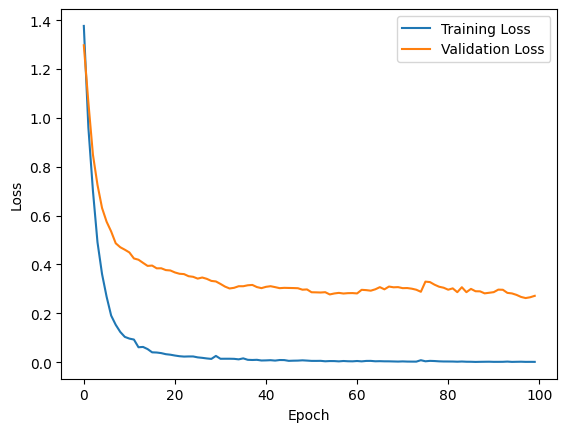

In [105]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

all_labels = []
all_predictions = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(y_batch.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

labels = np.unique(all_labels)  
unmap_labels = [reverse_mapping[label] for label in labels]
target_names = [f"{label}" for label in unmap_labels]

print(classification_report(all_labels, all_predictions, target_names=target_names, labels=labels))

              precision    recall  f1-score   support

         0.5       0.84      0.95      0.89        60
        0.75       0.92      0.92      0.92        49
         1.0       0.98      0.84      0.90        55
        1.25       0.96      0.96      0.96        57

    accuracy                           0.92       221
   macro avg       0.93      0.92      0.92       221
weighted avg       0.92      0.92      0.92       221



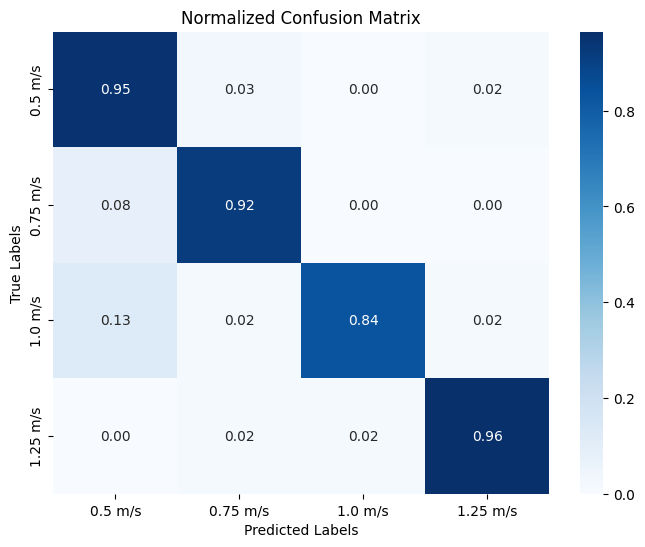

In [109]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

class_names = ["0.5 m/s", "0.75 m/s", "1.0 m/s", "1.25 m/s"]

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()
